In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.nn import functional as F
import random
from sklearn.utils import resample
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/taxonomy_engagement_data.csv')

In [ ]:
df.fillna({'msEngagement': 0}, inplace=True)
data_clean = df.groupby(['content_id']).agg({'prompt': 'first', 'msEngagement': 'mean', 'is_like': 'mean', 'is_dislike': 'mean'}).reset_index()
scaler = MinMaxScaler()
data_clean['msEngagement'] = scaler.fit_transform(data_clean[['msEngagement']])
data_clean['interaction'] = (data_clean['is_like'] - data_clean['is_dislike'])*1.5 + data_clean['msEngagement'] # weigh likes a little bit more than engagement
scaler = MinMaxScaler(feature_range=(-1, 1))
data_clean['interaction'] = scaler.fit_transform(data_clean[['interaction']])

{'whiskers': [<matplotlib.lines.Line2D at 0x7a4f52a653f0>,
 'caps': [<matplotlib.lines.Line2D at 0x7a4f52a67160>,
 'boxes': [<matplotlib.lines.Line2D at 0x7a4f52a66590>],
 'medians': [<matplotlib.lines.Line2D at 0x7a4f52a666e0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7a4f52a669e0>],
 'means': []}

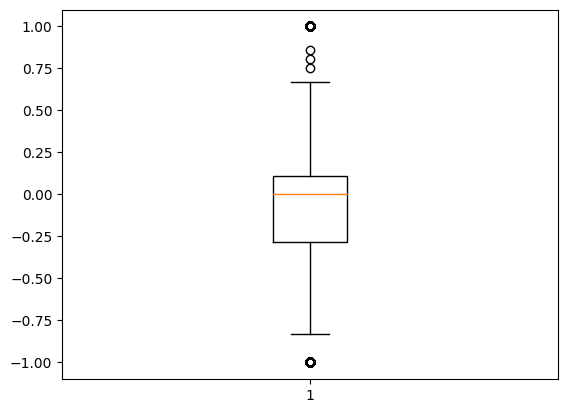

In [ ]:
plt.boxplot(data_clean['interaction'])

In [ ]:
# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.0
# ------------

torch.manual_seed(1337)

In [ ]:
class DataLoader:
    def __init__(self, input, scores=None, seq_length=block_size, batch_size=batch_size, test_size=0.2, val_size=0.2):
        self.input = input
        self.seq_length = seq_length
        self.batch_size = batch_size
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.vocab_size = self.tokenizer.vocab_size
        text_data = input['prompt'].tolist()
        scores = input['interaction'].tolist()
        tokenized_text_gen = [self.tokenizer.encode(seq, add_special_tokens=True, max_length=self.seq_length + 1, truncation=True, padding='max_length')for seq in text_data]
        self.X_train_gen, X_temp_gen = train_test_split(tokenized_text_gen, test_size=test_size, random_state=42)
        self.X_val_gen, self.X_test_gen = train_test_split(X_temp_gen, test_size=val_size, random_state=42)

        tokenized_text_reg = [self.tokenizer.encode(seq, add_special_tokens=True, max_length=self.seq_length, truncation=True, padding='max_length') for seq in text_data]
        self.X_train_reg, X_temp_reg, self.y_train_reg, y_temp_reg = train_test_split(tokenized_text_reg, scores, test_size=test_size, random_state=42)
        self.X_val_reg, self.X_test_reg, self.y_val_reg, self.y_test_reg = train_test_split(X_temp_reg, y_temp_reg, test_size=val_size, random_state=42)

        self.batch_start_indices = {
            'train': 0,
            'val': 0,
            'test': 0
        }

    def get_batch(self, split='train', task='text_generation'):
        if task == 'text_generation':
            if split == 'train':
                data = self.X_train_gen
            elif split == 'val':
                data = self.X_val_gen
            elif split == 'test':
                data = self.X_test_gen
            targets = None
        elif task == 'regression':
            if split == 'train':
                data, targets = self.X_train_reg, self.y_train_reg
            elif split == 'val':
                data, targets = self.X_val_reg, self.y_val_reg
            elif split == 'test':
                data, targets = self.X_test_reg, self.y_test_reg

        ## train in original order
        # start_idx = self.batch_start_indices[split]
        # end_idx = start_idx + self.batch_size

        # if end_idx > len(data):
        #     end_idx = len(data)

        # batch_seqs = data[start_idx:end_idx]

        # self.batch_start_indices[split] = end_idx % len(data)

        batch_indices = np.random.choice(len(data), size=self.batch_size, replace=False)
        batch_seqs = [data[i] for i in batch_indices]

        if task == 'text_generation':
            input_tensor = torch.tensor([seq[:-1] for seq in batch_seqs], dtype=torch.long)
            target_tensor = torch.tensor([seq[1:] for seq in batch_seqs], dtype=torch.long)
        elif task == 'regression':
            batch_targets = [targets[i] for i in batch_indices]
            input_tensor = torch.tensor(batch_seqs, dtype=torch.long)
            target_tensor = torch.tensor(batch_targets, dtype=torch.float32)

        return input_tensor, target_tensor

    def generate_next_token(self, model, input_seq, max_new_tokens):
        model.eval()
        input_tokens = self.tokenizer.encode(input_seq, return_tensors='pt', max_length=self.seq_length+1, truncation=True).to(device)

        generated_seq = input_seq
        for _ in range(max_new_tokens):
            with torch.no_grad():
                logits = model(input_tokens)
                predicted_token_id = torch.argmax(logits[:, -1, :], dim=-1).item()
                predicted_token = self.tokenizer.decode([predicted_token_id])
                generated_seq += predicted_token

                input_tokens = torch.cat([input_tokens, torch.tensor([[predicted_token_id]], dtype=torch.long).to(device)], dim=1)
                if input_tokens.size(1) >= self.seq_length:
                    break

        return generated_seq

In [ ]:
data_loader = DataLoader(data_clean)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

In [ ]:
# super simple bigram model
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        vocab_size = data_loader.vocab_size
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        # C - channel size, embedding dimension*vocab size
        # B - batch size
        # T - seq length/block size
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        return logits

In [ ]:
# regression model
class RegressionModel(nn.Module):

    def __init__(self, pretrained_model):
        super().__init__()

        self.token_embedding_table = pretrained_model.token_embedding_table
        self.position_embedding_table = pretrained_model.position_embedding_table
        self.blocks = pretrained_model.blocks
        self.ln_f = pretrained_model.ln_f  # final layer norm
        self.regression_head = nn.Sequential(nn.Linear(n_embd, 1), nn.Tanh()) # output a single regression score

    def forward(self, idx):
        B, T = idx.shape
        tok_emb = self.token_embedding_table(idx)  # (B, T, C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=idx.device))  # (T, C)
        x = tok_emb + pos_emb  # (B, T, C)
        x = self.blocks(x)  # (B, T, C)
        x = self.ln_f(x)  # (B, T, C)
        x = x.mean(dim=1)  # (B, C) average over the time dimension to get a single vector per batch
        score = self.regression_head(x)  # (B, 1)

        return score

In [ ]:
# exclude padding tokens to prevent overfitting
def masked_cross_entropy(logits, target, pad_token_id):
    mask = (target != pad_token_id).float() # (B,T)
    loss = F.cross_entropy(logits.view(-1, logits.size(-1)), target.view(-1), reduction='none') # (B*T, C) (B*T)
    # loss (B*T)
    mask = mask.view(-1) # (B*T)
    masked_loss = (loss * mask).sum() / mask.sum()

    return masked_loss

def train_generation_model(model, data_loader, epochs=50, eval_interval=5, learning_rate=learning_rate):
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        batch_train_losses = []
        for _ in range(len(data_loader.X_train_gen) // data_loader.batch_size):
            X, y = data_loader.get_batch(split='train', task='text_generation')
            X, y = X.to(device), y.to(device)

            # forward
            logits = model(X)
            B, T, C = logits.shape
            # print(logits.shape, y.shape)
            loss = masked_cross_entropy(logits, y, data_loader.tokenizer.pad_token_id)
            batch_train_losses.append(loss.item())

            # backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        avg_train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(avg_train_loss)

        if (epoch+1) % eval_interval == 0:
            model.eval()
            batch_val_losses = []
            with torch.no_grad():
                for _ in range(len(data_loader.X_val_gen) // data_loader.batch_size):
                    X, y = data_loader.get_batch(split='val', task='text_generation')
                    X, y = X.to(device), y.to(device)
                    logits = model(X)
                    B, T, C = logits.shape
                    val_loss = masked_cross_entropy(logits, y, data_loader.tokenizer.pad_token_id)
                    batch_val_losses.append(val_loss.item())

            avg_val_loss = sum(batch_val_losses) / len(batch_val_losses)
            val_losses.append(avg_val_loss)
            print(f"Epoch {epoch+1}/{epochs}, train Loss: {avg_train_loss:.4f}, val Loss: {avg_val_loss:.4f}")

    plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, epochs + 1, eval_interval), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    return model

In [ ]:
def train_regression_model(pretrained_model, data_loader, epochs=50, eval_interval=5, learning_rate=learning_rate):
    model = RegressionModel(pretrained_model)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    loss_fn = nn.MSELoss()

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        batch_train_losses = []
        for _ in range(len(data_loader.X_train_reg) // data_loader.batch_size):
            X, y = data_loader.get_batch(split='train', task='regression')
            X, y = X.to(device), y.to(device)

            # forward
            outputs = model(X).squeeze()
            loss = loss_fn(outputs, y)
            batch_train_losses.append(loss.item())

            # backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        avg_train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(avg_train_loss)

        if (epoch+1) % eval_interval == 0:
            model.eval()
            batch_val_losses = []
            with torch.no_grad():
                for _ in range(len(data_loader.X_val_reg) // data_loader.batch_size):
                    X, y = data_loader.get_batch(split='val', task='regression')
                    X, y = X.to(device), y.to(device)
                    outputs = model(X).squeeze()
                    val_loss = loss_fn(outputs, y)
                    batch_val_losses.append(val_loss.item())

            avg_val_loss = sum(batch_val_losses) / len(batch_val_losses)
            val_losses.append(avg_val_loss)
            print(f"Epoch {epoch+1}/{epochs}, train Loss: {avg_train_loss:.4f}, val Loss: {avg_val_loss:.4f}")

    plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, epochs + 1, eval_interval), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    return model

Epoch 5/50, train Loss: 3.8924, val Loss: 4.3088
Epoch 10/50, train Loss: 3.5155, val Loss: 4.1828
Epoch 15/50, train Loss: 3.2954, val Loss: 4.1259
Epoch 20/50, train Loss: 3.1630, val Loss: 4.0741
Epoch 25/50, train Loss: 3.0724, val Loss: 4.1057
Epoch 30/50, train Loss: 2.9859, val Loss: 4.0769
Epoch 35/50, train Loss: 2.9421, val Loss: 4.0773
Epoch 40/50, train Loss: 2.8863, val Loss: 4.1672
Epoch 45/50, train Loss: 2.8609, val Loss: 4.1617
Epoch 50/50, train Loss: 2.8352, val Loss: 4.1948


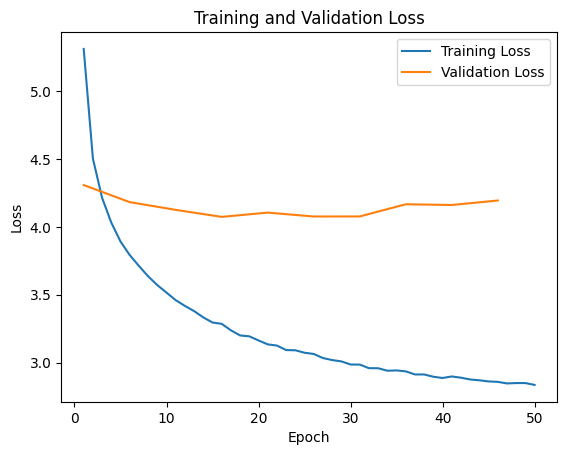

In [ ]:
model = BigramLanguageModel()
trained_model = train_generation_model(model, data_loader)
torch.save(trained_model.state_dict(), 'pretrained_model.pth')

In [ ]:
# from google.colab import files
# files.download('pretrained_model.pth')
print(data_loader.generate_next_token(trained_model, '8k', max_new_tokens=500))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

8koverthestreet,aphoto##real##istic,highlydetailed,digitalpainting,arts##tation,conceptart,smooth,sharpfocus,illustration,


<ipython-input-13-585486140db3>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_model.load_state_dict(torch.load('pretrained_model.pth'))


Epoch 5/50, train Loss: 0.0581, val Loss: 0.1257
Epoch 10/50, train Loss: 0.0381, val Loss: 0.1358
Epoch 15/50, train Loss: 0.0326, val Loss: 0.1388
Epoch 20/50, train Loss: 0.0286, val Loss: 0.1293
Epoch 25/50, train Loss: 0.0276, val Loss: 0.1381
Epoch 30/50, train Loss: 0.0270, val Loss: 0.1282
Epoch 35/50, train Loss: 0.0262, val Loss: 0.1321
Epoch 40/50, train Loss: 0.0261, val Loss: 0.1395
Epoch 45/50, train Loss: 0.0255, val Loss: 0.1356
Epoch 50/50, train Loss: 0.0250, val Loss: 0.1315


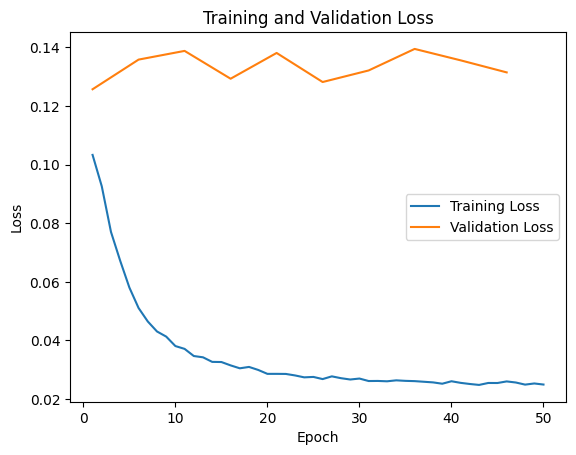

In [ ]:
pretrained_model = BigramLanguageModel()
pretrained_model.load_state_dict(torch.load('pretrained_model.pth', weights_only=True))
pretrained_model.to(device)
regression_model = train_regression_model(pretrained_model, data_loader)

In [ ]:
torch.save(regression_model.state_dict(), 'regression_model.pth')
# from google.colab import files
# files.download('regression_model.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
def test_regression_model(model, data_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    predictions = []
    actuals = []

    with torch.no_grad():
        for _ in range(len(data_loader.X_test_reg) // data_loader.batch_size):
            X, y = data_loader.get_batch(split='test', task='regression')
            X, y = X.to(device), y.to(device)

            outputs = model(X).squeeze()
            predictions.extend(outputs.cpu().numpy())
            actuals.extend(y.cpu().numpy())

    mse = mean_squared_error(actuals, predictions)
    print(f"Test MSE: {mse:.4f}")

    plt.figure(figsize=(10, 6))
    plt.plot(actuals, label='Actual Values', marker='o', linestyle='-', color='blue')
    plt.plot(predictions, label='Predicted Values', marker='x', linestyle='--', color='purple')
    plt.xlabel('Sample')
    plt.ylabel('Value')
    plt.title('Predictions vs Actual Values')
    plt.legend()
    plt.show()

Test MSE: 0.1249


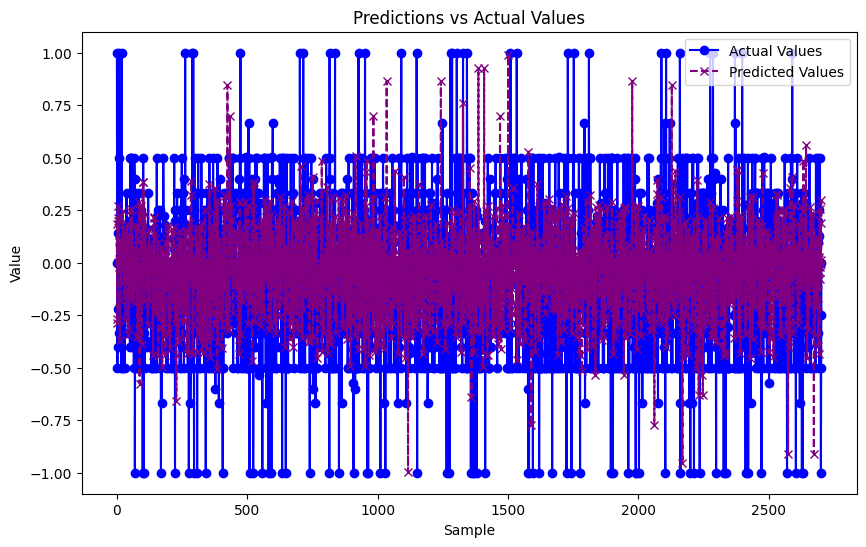

In [ ]:
pretrained_model = BigramLanguageModel()
pretrained_model.load_state_dict(torch.load('pretrained_model.pth', weights_only=True))
pretrained_model.to(device)
regression_model = RegressionModel(pretrained_model)
regression_model.load_state_dict(torch.load('regression_model.pth', weights_only=True))
regression_model.to(device)
test_regression_model(regression_model, data_loader)

In [ ]:
def predict_score(prompt, regression_model, data_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    regression_model.to(device)
    regression_model.eval()

    input_tokens = data_loader.tokenizer.encode(prompt, add_special_tokens=True, max_length=data_loader.seq_length, truncation=True, padding='max_length')
    input_tensor = torch.tensor([input_tokens], dtype=torch.long).to(device)

    with torch.no_grad():
        predicted_score = regression_model(input_tensor).squeeze().item()

    return predicted_score

user_prompt = "Peter steps into a dingy kitchen. A dirty coffee cup and a plate sit on the counter near the sink. At the other end of the kitchen, past the refrigerator, is a door leading outside. Peter approaches the door, glances through the window. He then turns and walks through a doorway.\\\\n. In the style of the movie Lost-Souls. dim volumetric cinematic lighting, 8k"
predicted_interaction = predict_score(user_prompt, regression_model, data_loader)
print(f"predicted interaction: {predicted_interaction:.4f}")

predicted interaction: 0.8273
